In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
#Inspect Measurment class
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
#Inspect Station class
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)
    
for date in latest_date:
    date_now = date.date

date_now = dt.datetime.strptime(date_now, "%Y-%m-%d")

# Calculate the date 1 year ago from today
date_oneyear_ago = date_now - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_oneyear_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data).dropna()

# Sort the dataframe by date (done above when performing query)
df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
4,2016-08-24,1.22
5,2016-08-24,2.15


In [24]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.style.use('fivethirtyeight')

f1 = plt.plot(df["date"], df["prcp"])
plt.title("Precipitation in Hawaii")
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")


# Rotate the xticks for the dates
plt.xticks(rotation= 75)

plt.savefig("Precipation in Hawaii.png")



In [25]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [26]:
# How many stations are available in this dataset?
station_sum = session.query(Measurement.station).distinct().count()
print (station_sum)

9


In [27]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station)).distinct().group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:

# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = session.query(Station.station, func.count(Measurement.station)).group_by(Measurement.station).order_by\
    (func.count(Measurement.station).desc()).limit(1)[0][0]

calc = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

most_active_station_tob = session.query(*calc).filter(Measurement.station == most_active_station).all()
most_active_station_tob

[(58.0, 84.0, 70.91500765696784)]

In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and put in DataFrame to plot
busiest_station_tobs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date > date_oneyear_ago).\
    order_by(Measurement.date).all()

busiest_station_tobs_df = pd.DataFrame(busiest_station_tobs, columns= ["Date", "Tobs"])
busiest_station_tobs_df.head()

,Date,Tobs
0,2016-08-24,74.0
1,2016-08-25,77.0
2,2016-08-27,74.0
3,2016-08-28,71.0
4,2016-08-29,78.0


<IPython.core.display.Javascript object>


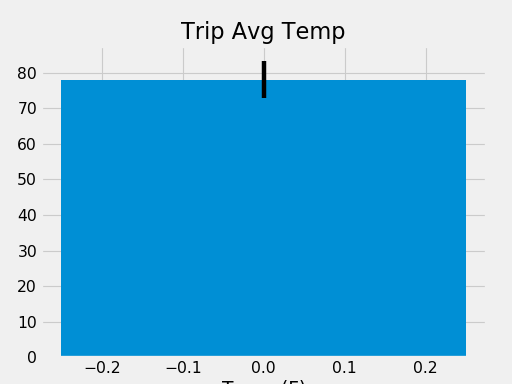

<IPython.core.display.Javascript object>


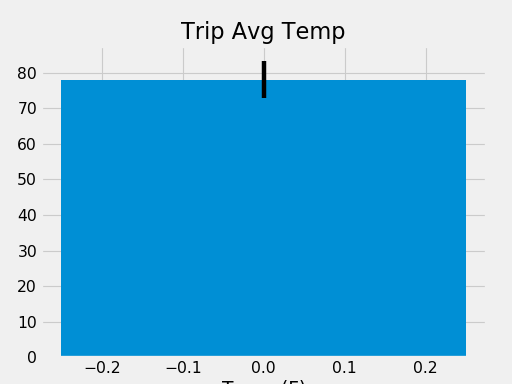

In [31]:
# Plot DataFrame above as a histogram

f2= plt.hist(busiest_station_tobs_df['Tobs'], bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")
plt.title("Most Active Station's Temperature Observations")\

plt.savefig("Most Active Station TOB")
plt.figure()


In [33]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [34]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = "2017-07-04"
end_date = "2017-07-15"
vac_temps = calc_temps(start_date, end_date)
vac_temps

[(69.0, 78.11842105263158, 82.0)]

In [35]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmax = vac_temps[0][2] - vac_temps[0][1]
tmin = vac_temps[0][1] - vac_temps[0][0]

f3 = plt.bar(0, vac_temps[0][1], yerr= [tmax-tmin], width = 0.5)
plt.title("Trip Avg Temp")
plt.xlabel("Temp (F)")

plt.savefig("Trip Avg Temp.png")
